In [42]:
#%reset -f
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection #for plots polygons as rasters
import xarray as xr
from datetime import datetime, timedelta as delta
from matplotlib import path
from scipy.spatial import KDTree, cKDTree #c implementation is faster (to find nearest neighbor)
import os
import dask as da
from tqdm import tqdm
import glob
#K-Means
from sklearn.cluster import KMeans #scikit-learn to perform K-Means
#coefs to evaluate the K-Mean performance:
from sklearn.metrics import silhouette_score, silhouette_samples
from kneed import KneeLocator #to find the elbow method in SSE for evaluation of K-Means

In [3]:
#inputs----------
#path of directories
homee = "/export/lv4/user/jfajardourbina/"
dir_vel= f"{homee}dws_ulf_getm_2D_depth_avg/data/velocity/"
savee='everyM2' #saving track data every m2
deploy='everyM2'#deploy set of particles every m2
minTsim=60 #mimimum time of simulation (days)
maxTsim=91 #maximum time of simulation (days)
dir_tracks = f"{homee}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/exp-deployHighVolume_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d/tracks/"
dir_dws_bound = f"{homee}dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_dws_boundaries/"
#files
files_vel_root="RE.DWS200m.uvz."
file_dws_bound0="dws_boundaries_contour0.nc"; #contour of DWS are the land points closest to ocean points
file_dws_bound0p5="dws_boundaries_contour0p5.nc"
#parameters
npa_per_dep=12967 #number of particles per deployment
m2=int(12.42*3600+2) #period in seconds

#info required for output files----
#nobs_max=117   #all particles will have trajectories with duration approx 60 days, but nan data for the ones that leave the numerical domain before it
nobs_max=-1     #select all observations, approx 91 days
dir_out_data=f"{homee}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/exp-deployHighVolume_coords-xcyc_save-everyM2_deploy-everyM2_Tsim-{minTsim}-{maxTsim}d/post_proc_data/"
Ndep=1

In [4]:
#open dws boundaries----
dsp0=xr.open_dataset(dir_dws_bound+file_dws_bound0)
bdr_dws0=dsp0.bdr_dws.values #points that define DWS

In [5]:
#open dws boundaries----
names_tr=["marsdiep","eierlandsgat","vlie","borndiep","pinkegat","watershed1"]
names_islands=["coast","texel","vlieland","terschelling","ameland","schiermonnikoog"]
#contour0 (inlets and boundaries along coast and islands)
dsb0=xr.open_dataset(dir_dws_bound+file_dws_bound0) #float64
bdr_dws0=dsb0.bdr_dws.values #points that define DWS
#contour0p5 (inlets and boundaries defined approx 100m from the points along the coast)
dsb0p5=xr.open_dataset(dir_dws_bound+file_dws_bound0p5) 
bdr_dws0p5=dsb0p5.bdr_dws.values #points that define DWS

In [6]:
#select contour for beaching---
#bdr_dws=bdr_dws0; dsb=dsb0 #contour0
bdr_dws=bdr_dws0p5; dsb=dsb0p5 #contour0.5 (this remove alot stuck particles)

In [7]:
tti=np.datetime64('1980-01')
tte=np.datetime64('2015-10')
time_year_month=np.arange(tti,tte+1,1,dtype='datetime64[M]') #+1s to get the last date

In [8]:
if nobs_max==-1: nobs_max=177

In [11]:
tti=np.datetime64('1980-01')
tte=np.datetime64('2015-10')
time_year_month=np.arange(tti,tte+1,1,dtype='datetime64[M]') #+1s to get the last date
#open particle trajectories---
i=time_year_month[0]
year_sim=int(str(i)[:4]); month_sim=int(str(i)[5:7])
file_track=f'tracks_{year_sim}{month_sim:02d}_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d.nc'
file_track_path=f'{dir_tracks}{year_sim}/{file_track}'  
dst=xr.open_dataset(file_track_path, chunks={'traj': npa_per_dep}) #float32, a bit faster than npa_per_dep*10 when .compute data for this case
dst.close()

In [12]:
#open velocity file---
file_vel_path=f"{dir_vel}{files_vel_root}{year_sim}{month_sim:02d}01.nc" #:02d includes leading zeros (at the begin)
ds=xr.open_dataset(file_vel_path,chunks={'xc':-1,'yc':-1,'time':110}) #chunks every 36h
xc=ds.xc; yc=ds.yc; h=ds.bathymetry.load()

In [13]:
files_nc_paths=sorted(glob.glob(f'{dir_out_data}nobsmax_{nobs_max}_{int((nobs_max-1)*m2/86400)}d/netcdf_data/**/*.nc',recursive=True)) # "**"" represent all the "month" directories
rt_xy=[]
for i in tqdm(files_nc_paths):
    dss=xr.open_dataset(i).load()
    rt_xy.append(dss.rt)
    #
    dss.close(); del dss
rt_xy=xr.concat(rt_xy,dim='timedep')

100%|██████████| 430/430 [00:16<00:00, 25.82it/s]


In [193]:
rt_xy_clim0 = rt_xy.groupby('timedep.month').mean(dim='timedep')

In [151]:
#remove nans
ind_nan=np.unique(np.nonzero(np.isnan(rt_xy_clim0))[1])
ind_finit=np.setdiff1d(np.arange(npa_per_dep),ind_nan)
rt_xy_clim=rt_xy_clim0.isel(npar=ind_finit).T 
rt_xy_clim.close()
rt_xy_clim.shape

(12964, 12)

### Kmeans with 7 cluster

In [43]:
n=7 #clusters
kmeans = KMeans(n_clusters=n, random_state=0).fit(rt_xy_clim) 

In [44]:
# The number of iterations required to converge
kmeans.n_iter_

11

In [45]:
# The SSE value
kmeans.inertia_

1006033.3751726144

In [46]:
# Get the cluster labels
labels=kmeans.labels_
labels

array([4, 3, 1, ..., 6, 6, 6], dtype=int32)

In [48]:
# Calculate silhouette_score
print(silhouette_score(rt_xy_clim, kmeans.labels_))

0.4194011128509244


In [50]:
#get all silhouett values and compute the mean (same as above)
sil_vals=silhouette_samples(rt_xy_clim, kmeans.labels_)
print(sil_vals.mean())

0.4194011128509244


In [55]:
sil_vals_clus=[];lens=[]
for i in range(n):
    ii=np.where(labels==i)[0]
    sil_vals0=sil_vals[ii];sil_vals0.sort()
    sil_vals_clus.append(sil_vals0) #order accord to ascending values
    lens.append(len(sil_vals0))

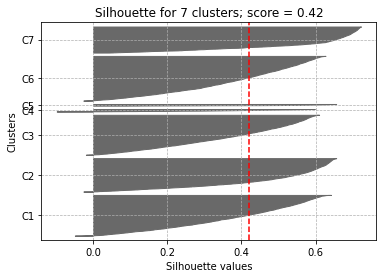

In [72]:
# plot all silhouette values for each cluster
l1=np.concatenate([np.zeros(1),np.cumsum(lens)])
labs_avg=[]
for i in range(n):
    labs=np.arange(l1[i],l1[i+1])+lens[1]//10*i
    labs_avg.append(labs.mean())
    plt.fill_betweenx(labs,0,sil_vals_clus[i],color='dimgrey')
plt.yticks(labs_avg,['C'+str(i) for i in range(1,n+1)]);
aa=labs.max()//50
plt.vlines(x=sil_vals.mean(),ymin=-aa,ymax=labs.max()+aa,ls='--',colors='r')
plt.grid(linewidth=.7,ls='--'); plt.xlabel('Silhouette values'); plt.ylabel('Clusters')
plt.ylim([-aa,labs.max()+aa]); plt.title(f'Silhouette for {n} clusters; score = {sil_vals.mean():.2f}');

In [83]:
#recover the original size of the array
rt_xy_labels=np.zeros(npa_per_dep)*np.nan
rt_xy_labels[ind_finit]=labels+1

In [84]:
#plot---

In [79]:
x0=dst.x.isel(traj=range(npa_per_dep),obs=0).values; y0=dst.y.isel(traj=range(npa_per_dep),obs=0)
pxy0=np.c_[x0,y0]/1e3
dx=400/1e3;dy=400/1e3
polys0=[]
for i in range(pxy0.shape[0]):
    jj=np.array([[pxy0[i,0]-dx/2,pxy0[i,1]-dy/2], [pxy0[i,0]+dx/2,pxy0[i,1]-dy/2],
                 [pxy0[i,0]+dx/2,pxy0[i,1]+dy/2], [pxy0[i,0]-dx/2,pxy0[i,1]+dy/2]])
    polys0.append(jj) #4 coordinates of a square

Text(0.5, 1.0, 'RT')

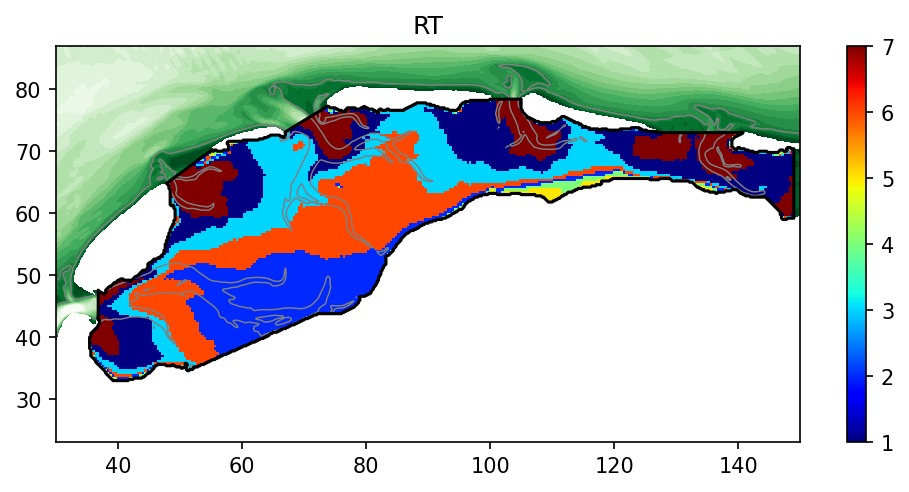

In [94]:
#mean RT-----
val=rt_xy_labels #rt(deployes,npa_per_dep)
#
fig,ax=plt.subplots(1,1,figsize=(8,3.5),dpi=150)
ax.plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'-k',lw=1.5)
ax.contourf(xc/1e3,yc/1e3,h,levels=32,vmin=-2,vmax=32,cmap='Greens_r')
ax.contour(xc/1e3,yc/1e3,h,[5],colors='grey',linewidths=.7)
pc = PolyCollection(polys0,cmap='jet') 
val = np.ma.array(val, mask=np.isnan(val)) #mask because array idtrmout has nan values
pc.set_array(val);pc.set_clim([1,7])
ax.add_collection(pc); plt.colorbar(pc,ax=ax)
ax.plot()
ax.axis('equal');ax.axis([30,150,30,80]); ax.set_title("RT")

In [166]:
#h2=h.values*1;h2[h2<=-.7]=np.nan
#fig,ax=plt.subplots(1,1,figsize=(8,3.5),dpi=150)
#ax.plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'-k',lw=.5)
#ax.contourf(xc/1e3,yc/1e3,h2,levels=32,vmin=-2,vmax=32,cmap='jet')
#ax.contour(xc/1e3,yc/1e3,h2,[5],colors='grey',linewidths=.7)


In [162]:
#From the above figure is clear that we should remove points that are on banks
#find index for no nan values
ind_nan=np.unique(np.nonzero(np.isnan(rt_xy_clim0))[1])
ind_finit=np.setdiff1d(np.arange(npa_per_dep),ind_nan)
#find index for banks that are above 70cm of mean sea level
traj0=np.arange(npa_per_dep)
hp=np.diag(h.sel(xc=x0,yc=y0,method='nearest'))
ind_h=traj0[hp<=-.7]
#merge indexes
ind=np.setdiff1d(ind_finit,ind_h)
#rt_xy_clim.close()
rt_xy_clim=rt_xy_clim0.isel(npar=ind).T
rt_xy_clim.shape

(12404, 12)

### find the best number of clusters

In [175]:
%%time
#make computations for 10 clusters
num_clusters=10
clusters=np.arange(1,num_clusters+1)
sse=[]
silhouette_avg=[];silhouette_vals=[]
labels=[]
for k in tqdm(range(len(clusters))):
    kmeans = KMeans(n_clusters=clusters[k], random_state=0).fit(rt_xy_clim)
    sse.append(kmeans.inertia_)
    labels.append(kmeans.labels_)
    if k>1:
        sil_avg = silhouette_score(rt_xy_clim, kmeans.labels_) #only works for n_cluster>1
        sil_vals = silhouette_samples(rt_xy_clim, kmeans.labels_)
        silhouette_avg.append(sil_avg); silhouette_vals.append(sil_vals)
clusters_sil=clusters[1:] #only works for n_cluster>1

100%|██████████| 10/10 [00:52<00:00,  5.21s/it]

CPU times: user 16min 10s, sys: 29min, total: 45min 11s
Wall time: 52.1 s


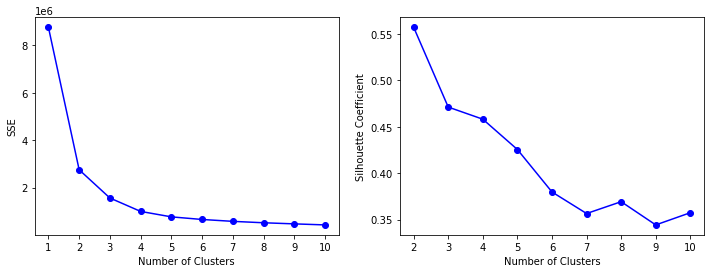

In [164]:
#So according to these coefficiets 3-4 clusters are the best?
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(clusters, sse,'-ob')
ax[0].set_xticks(clusters)
ax[0].set_xlabel("Number of Clusters")
ax[0].set_ylabel("SSE")
#
ax[1].plot(clusters_sil, silhouette_avg,'-ob')
ax[1].set_xticks(clusters_sil)
ax[1].set_xlabel("Number of Clusters")
ax[1].set_ylabel("Silhouette Coefficient");

In [165]:
#optimal amout of clusters with the elbow method:
#Determining the elbow point in the SSE curve
kl = KneeLocator(clusters, sse, curve="convex", direction="decreasing")
clust_elbow = kl.elbow
sse_elbow = np.array(sse)[clusters==clust_elbow][0]
print(f"sse elbow = {sse_elbow:.2f}; optimal clusters = {clust_elbow}")

sse elbow = 1563148.63; optimal clusters = 3


#### Results with 4 clusters:

Text(0.5, 1.0, 'RT')

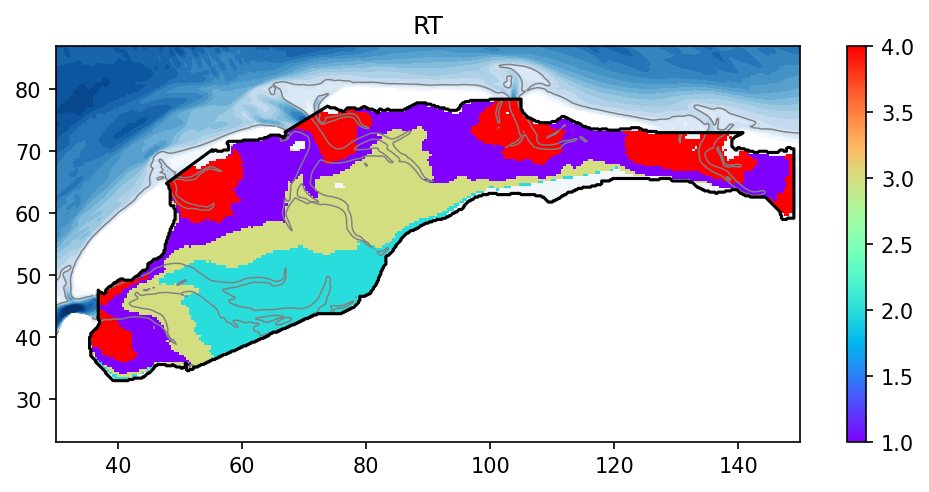

In [238]:
nn=4

#recover the original size of the array
rt_xy_labels=np.zeros(npa_per_dep)*np.nan
rt_xy_labels[ind]=labels[nn-1]+1

val=rt_xy_labels #rt(deployes,npa_per_dep)
fig,ax=plt.subplots(1,1,figsize=(8,3.5),dpi=150)
ax.plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'-k',lw=1.5)
ax.contourf(xc/1e3,yc/1e3,h,levels=32,vmin=-2,vmax=32,cmap='Blues')
ax.contour(xc/1e3,yc/1e3,h,[5],colors='grey',linewidths=.7)
pc = PolyCollection(polys0,cmap='rainbow') 
val = np.ma.array(val, mask=np.isnan(val)) #mask because array idtrmout has nan values
pc.set_array(val);pc.set_clim([1,nn])
ax.add_collection(pc); plt.colorbar(pc,ax=ax)
ax.plot()
ax.axis('equal');ax.axis([30,150,30,80]); ax.set_title("RT")

Text(0, 0.5, '(days)')

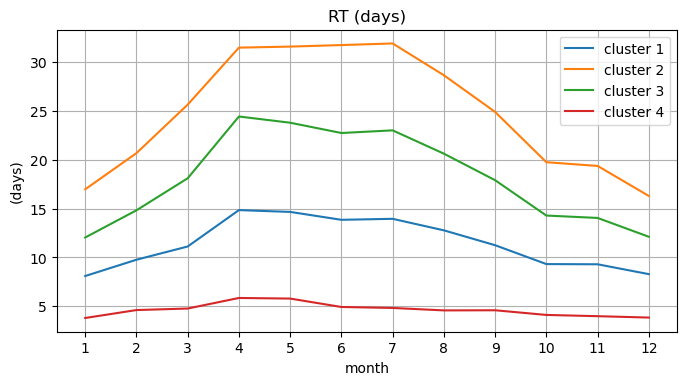

In [239]:
fig,ax=plt.subplots(1,1,figsize=(8,4),dpi=100)
for i in range(nn):
    rt_xy_clim0.isel(npar=traj0[rt_xy_labels==i+1]).mean(dim='npar').plot(label=f"cluster {i+1}")
ax.legend()
ax.set_xticks(range(1,13));ax.set_title("RT (days)");ax.grid();ax.set_ylabel("(days)")

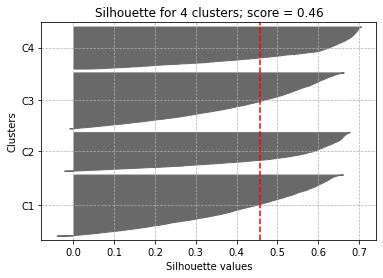

In [245]:
#get all silhouett values and compute the mean (same as above)
sil_vals=silhouette_samples(rt_xy_clim, labels[nn-1])
#print(sil_vals.mean())

sil_vals_clus=[];lens=[]
for i in range(nn):
    ii=np.where(labels[nn-1]==i)[0]
    sil_vals0=sil_vals[ii];sil_vals0.sort()
    sil_vals_clus.append(sil_vals0) #order accord to ascending values
    lens.append(len(sil_vals0))
    
# plot all silhouette values for each cluster
l1=np.concatenate([np.zeros(1),np.cumsum(lens)])
labs_avg=[]
for i in range(nn):
    labs=np.arange(l1[i],l1[i+1])+lens[1]//10*i
    labs_avg.append(labs.mean())
    plt.fill_betweenx(labs,0,sil_vals_clus[i],color='dimgrey')
plt.yticks(labs_avg,['C'+str(i) for i in range(1,nn+1)]);
aa=labs.max()//50
plt.vlines(x=sil_vals.mean(),ymin=-aa,ymax=labs.max()+aa,ls='--',colors='r')
plt.grid(linewidth=.7,ls='--'); plt.xlabel('Silhouette values'); plt.ylabel('Clusters')
plt.ylim([-aa,labs.max()+aa]); plt.title(f'Silhouette for {nn} clusters; score = {sil_vals.mean():.2f}');

#### Results with 5 clusters:

Text(0.5, 1.0, 'RT')

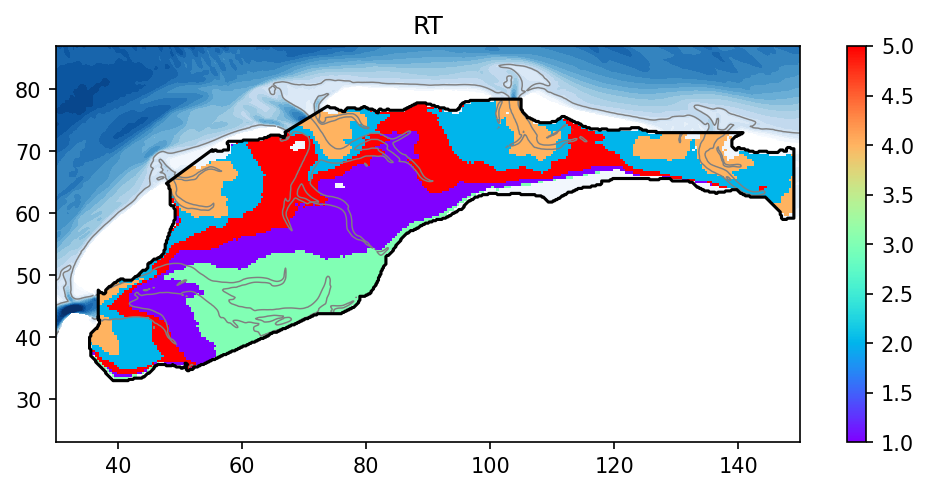

In [246]:
nn=5

#recover the original size of the array
rt_xy_labels=np.zeros(npa_per_dep)*np.nan
rt_xy_labels[ind]=labels[nn-1]+1

val=rt_xy_labels #rt(deployes,npa_per_dep)
fig,ax=plt.subplots(1,1,figsize=(8,3.5),dpi=150)
ax.plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'-k',lw=1.5)
ax.contourf(xc/1e3,yc/1e3,h,levels=32,vmin=-2,vmax=32,cmap='Blues')
ax.contour(xc/1e3,yc/1e3,h,[5],colors='grey',linewidths=.7)
pc = PolyCollection(polys0,cmap='rainbow') 
val = np.ma.array(val, mask=np.isnan(val)) #mask because array idtrmout has nan values
pc.set_array(val);pc.set_clim([1,nn])
ax.add_collection(pc); plt.colorbar(pc,ax=ax)
ax.plot()
ax.axis('equal');ax.axis([30,150,30,80]); ax.set_title("RT")

Text(0, 0.5, '(days)')

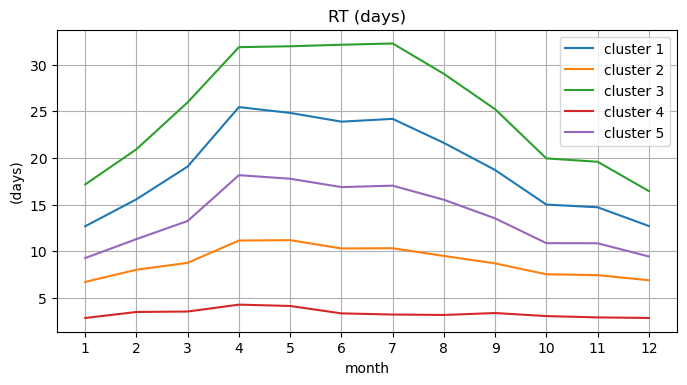

In [247]:
fig,ax=plt.subplots(1,1,figsize=(8,4),dpi=100)
for i in range(nn):
    rt_xy_clim0.isel(npar=traj0[rt_xy_labels==i+1]).mean(dim='npar').plot(label=f"cluster {i+1}")
ax.legend()
ax.set_xticks(range(1,13));ax.set_title("RT (days)");ax.grid();ax.set_ylabel("(days)")

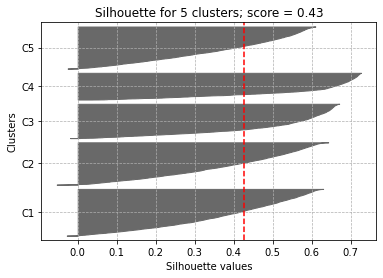

In [248]:
#get all silhouett values and compute the mean (same as above)
sil_vals=silhouette_samples(rt_xy_clim, labels[nn-1])
#print(sil_vals.mean())

sil_vals_clus=[];lens=[]
for i in range(nn):
    ii=np.where(labels[nn-1]==i)[0]
    sil_vals0=sil_vals[ii];sil_vals0.sort()
    sil_vals_clus.append(sil_vals0) #order accord to ascending values
    lens.append(len(sil_vals0))
    
# plot all silhouette values for each cluster
l1=np.concatenate([np.zeros(1),np.cumsum(lens)])
labs_avg=[]
for i in range(nn):
    labs=np.arange(l1[i],l1[i+1])+lens[1]//10*i
    labs_avg.append(labs.mean())
    plt.fill_betweenx(labs,0,sil_vals_clus[i],color='dimgrey')
plt.yticks(labs_avg,['C'+str(i) for i in range(1,nn+1)]);
aa=labs.max()//50
plt.vlines(x=sil_vals.mean(),ymin=-aa,ymax=labs.max()+aa,ls='--',colors='r')
plt.grid(linewidth=.7,ls='--'); plt.xlabel('Silhouette values'); plt.ylabel('Clusters')
plt.ylim([-aa,labs.max()+aa]); plt.title(f'Silhouette for {nn} clusters; score = {sil_vals.mean():.2f}');

#### Results with 6 clusters:

Text(0.5, 1.0, 'RT')

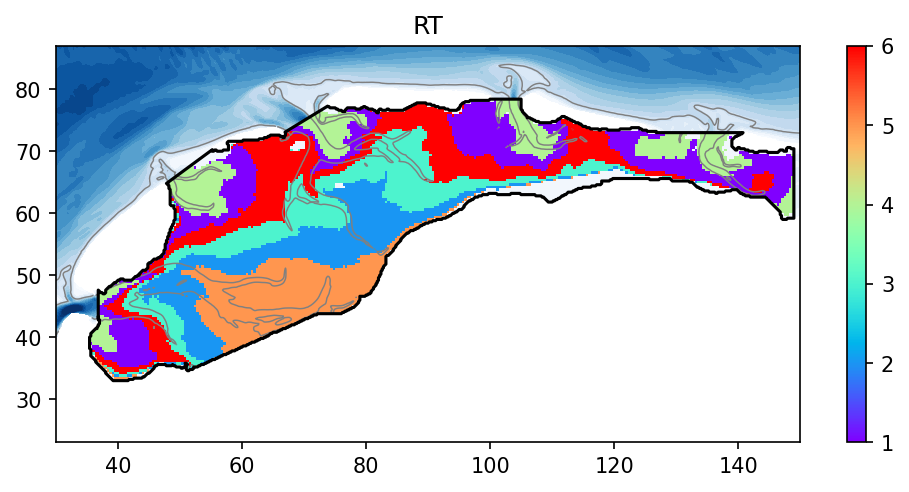

In [249]:
nn=6

#recover the original size of the array
rt_xy_labels=np.zeros(npa_per_dep)*np.nan
rt_xy_labels[ind]=labels[nn-1]+1

val=rt_xy_labels #rt(deployes,npa_per_dep)
fig,ax=plt.subplots(1,1,figsize=(8,3.5),dpi=150)
ax.plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'-k',lw=1.5)
ax.contourf(xc/1e3,yc/1e3,h,levels=32,vmin=-2,vmax=32,cmap='Blues')
ax.contour(xc/1e3,yc/1e3,h,[5],colors='grey',linewidths=.7)
pc = PolyCollection(polys0,cmap='rainbow') 
val = np.ma.array(val, mask=np.isnan(val)) #mask because array idtrmout has nan values
pc.set_array(val);pc.set_clim([1,nn])
ax.add_collection(pc); plt.colorbar(pc,ax=ax)
ax.plot()
ax.axis('equal');ax.axis([30,150,30,80]); ax.set_title("RT")

Text(0, 0.5, '(days)')

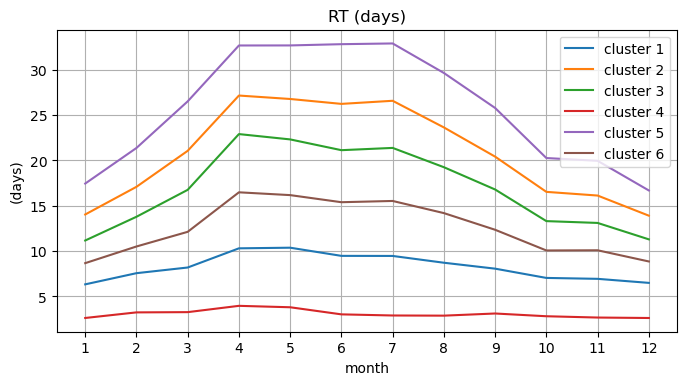

In [250]:
fig,ax=plt.subplots(1,1,figsize=(8,4),dpi=100)
for i in range(nn):
    rt_xy_clim0.isel(npar=traj0[rt_xy_labels==i+1]).mean(dim='npar').plot(label=f"cluster {i+1}")
ax.legend()
ax.set_xticks(range(1,13));ax.set_title("RT (days)");ax.grid();ax.set_ylabel("(days)")

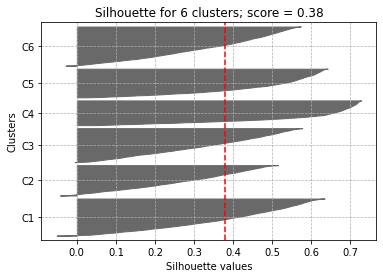

In [251]:
#get all silhouett values and compute the mean (same as above)
sil_vals=silhouette_samples(rt_xy_clim, labels[nn-1])
#print(sil_vals.mean())

sil_vals_clus=[];lens=[]
for i in range(nn):
    ii=np.where(labels[nn-1]==i)[0]
    sil_vals0=sil_vals[ii];sil_vals0.sort()
    sil_vals_clus.append(sil_vals0) #order accord to ascending values
    lens.append(len(sil_vals0))
    
# plot all silhouette values for each cluster
l1=np.concatenate([np.zeros(1),np.cumsum(lens)])
labs_avg=[]
for i in range(nn):
    labs=np.arange(l1[i],l1[i+1])+lens[1]//10*i
    labs_avg.append(labs.mean())
    plt.fill_betweenx(labs,0,sil_vals_clus[i],color='dimgrey')
plt.yticks(labs_avg,['C'+str(i) for i in range(1,nn+1)]);
aa=labs.max()//50
plt.vlines(x=sil_vals.mean(),ymin=-aa,ymax=labs.max()+aa,ls='--',colors='r')
plt.grid(linewidth=.7,ls='--'); plt.xlabel('Silhouette values'); plt.ylabel('Clusters')
plt.ylim([-aa,labs.max()+aa]); plt.title(f'Silhouette for {nn} clusters; score = {sil_vals.mean():.2f}');